# Notebook for testing and debugging Sequential Monte Carlo algorithms

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict
from math import ceil
import seaborn as sns

from approxmh.utilities import *
from approxmh.samplers import *
from approxmh.distributions import Banana, Funnel, create_gaussian_mixture, create_gaussian_lattice, create_random_gaussian_mixture, get_mode_coverage
from approxmh.distribution_metrics import *
from approxmh.sequential_mcmc import ULAKernel, run_annealed_importance_sampling, DensityMixture

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


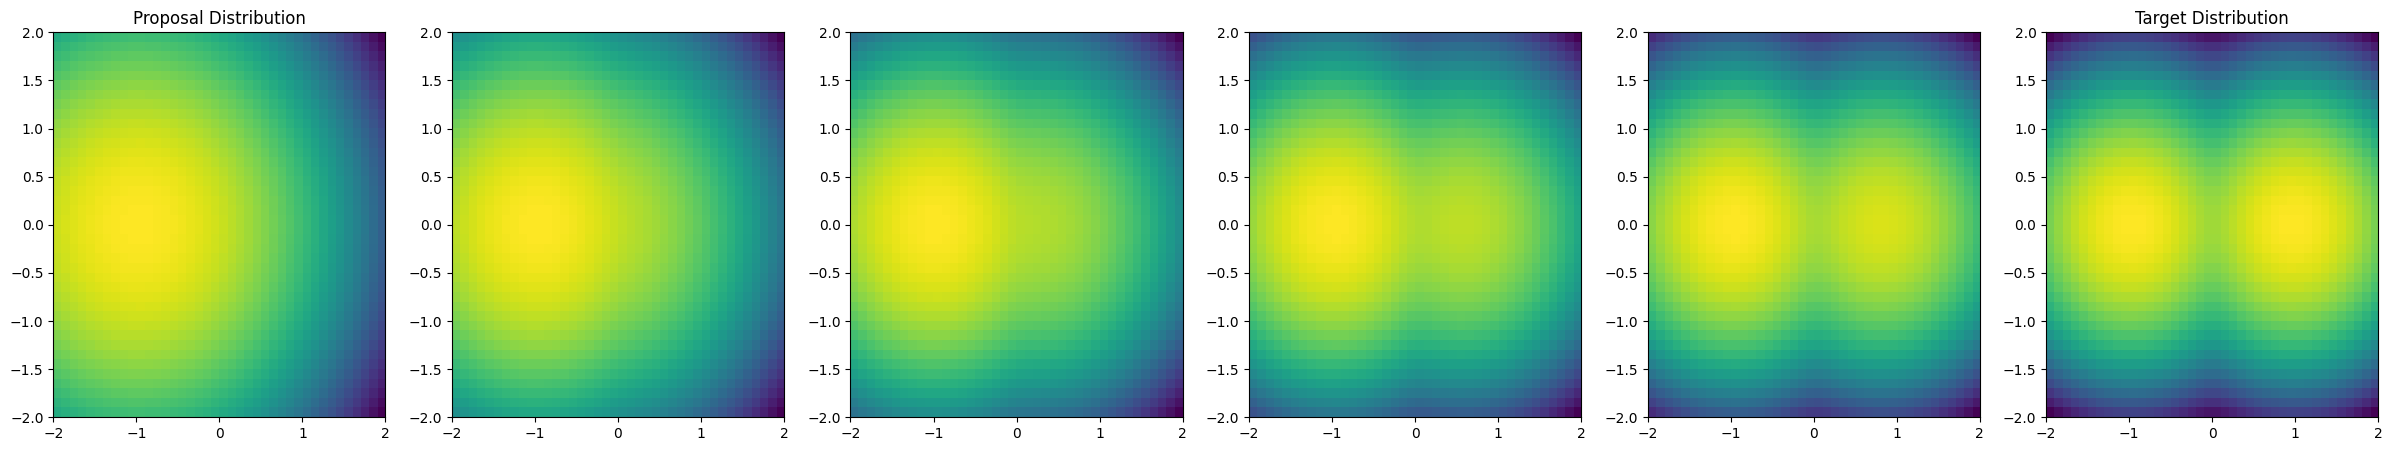

In [9]:
D = 2
proposal = torch.distributions.MultivariateNormal(torch.tensor([-1., 0.]), 0.5 * torch.eye(D))
target = create_gaussian_mixture(
    means = torch.tensor([[-1., 0.], [1., 0.]]),
    cov_matricies = 0.2 * torch.eye(2)
)

n_steps = 5
beta = torch.linspace(0, 1, n_steps + 1)

xlim=(-2, 2)
ylim = (-2, 2)
d = 40

fig, axs = plt.subplots(ncols=n_steps+1, figsize=(5*(n_steps+1), 5))
img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].set_title('Proposal Distribution')
img2 = plot_2d_torch_function(axs[-1], target.log_prob, xlim, ylim, d)
axs[-1].set_title('Target Distribution')
vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

for t in range(0, n_steps + 1):
    img = plot_2d_torch_function(axs[t], DensityMixture(proposal, 1 - beta[t], target, beta[t]).log_prob, xlim, ylim, d)
    #img.set_clim(*clim)

Weight Mean : 0.926800
Weight Variance : 4.711637


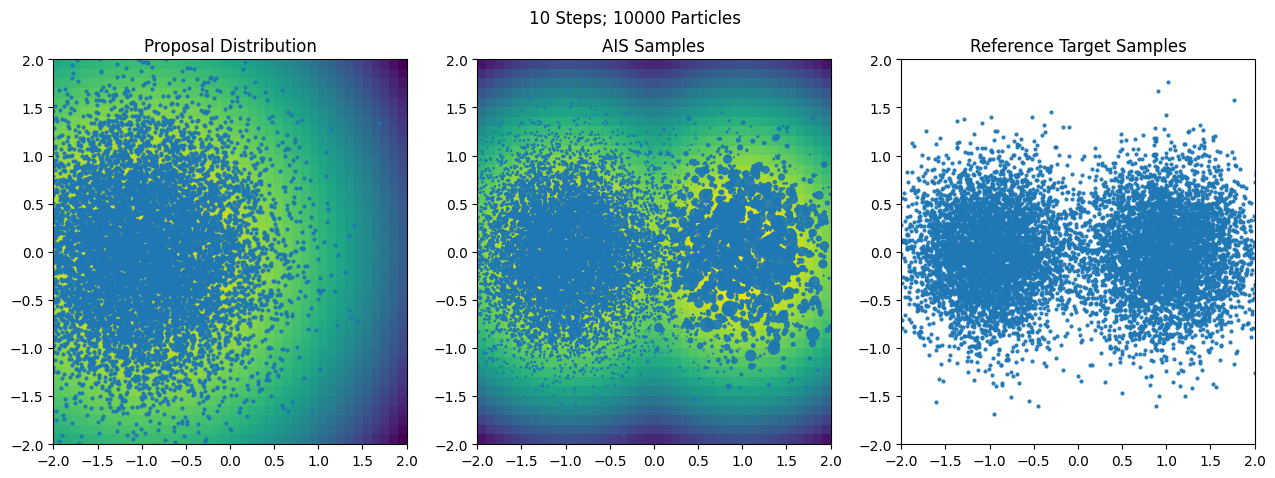

In [21]:
# ULA parameters
time_step = 0.13
# AIS parameters
n_steps = 10
n_particles = 10000
transition_kernel = lambda distr: ULAKernel(distr, time_step)

log_weights, ais_samples = run_annealed_importance_sampling(proposal, target, n_steps, n_particles, transition_kernel)

fig, axs = plt.subplots(ncols=3, figsize=(15.5, 5))
marker_s = 4
marker_alpha = 0.9

img1 = plot_2d_torch_function(axs[0], proposal.log_prob, xlim, ylim, d)
axs[0].scatter(*pl(proposal.sample((n_particles,))), s=marker_s, alpha=marker_alpha)
axs[0].set_title('Proposal Distribution')

img2 = plot_2d_torch_function(axs[1], target.log_prob, xlim, ylim, d)
axs[1].scatter(*pl(ais_samples), s=marker_s*log_weights.detach().exp().cpu(), alpha=marker_alpha)
axs[1].set_title('AIS Samples')

axs[2].scatter(*pl(target.sample((n_particles,))), s=marker_s, alpha=marker_alpha)
axs[2].set_title('Reference Target Samples')

for ax in axs:
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

vmin1, vmax1 = img1.get_clim()
vmin2, vmax2 = img2.get_clim()
clim = (min(vmin1, vmin2), max(vmax1, vmax2))
img1.set_clim(*clim)
img2.set_clim(*clim)

fig.suptitle(f'{n_steps} Steps; {n_particles} Particles')

average_weight = log_weights.exp().sum() / n_particles
weight_variance = torch.var(log_weights.exp())
print(f'Weight Mean : {average_weight:0.6f}')
print(f'Weight Variance : {weight_variance:0.6f}')

Text(0.5, 1.0, 'Distribution of AIS Logarithmic Importance Weights')

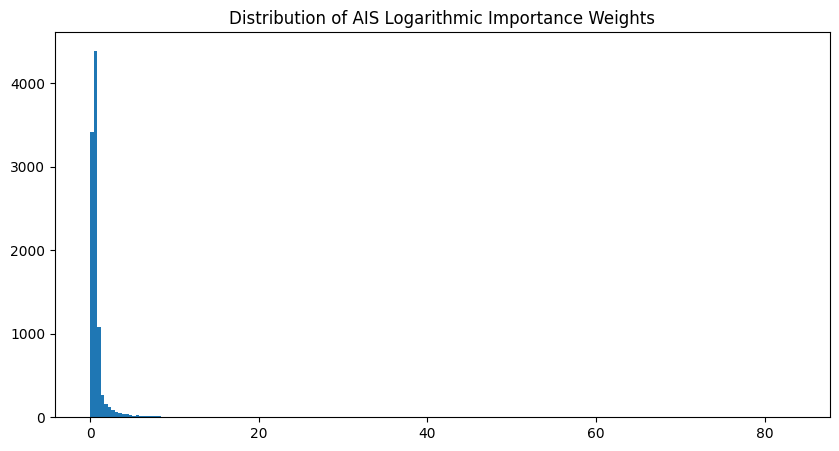

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hist(to_numpy(log_weights.exp()), bins=200)
ax.set_title('Distribution of AIS Logarithmic Importance Weights')

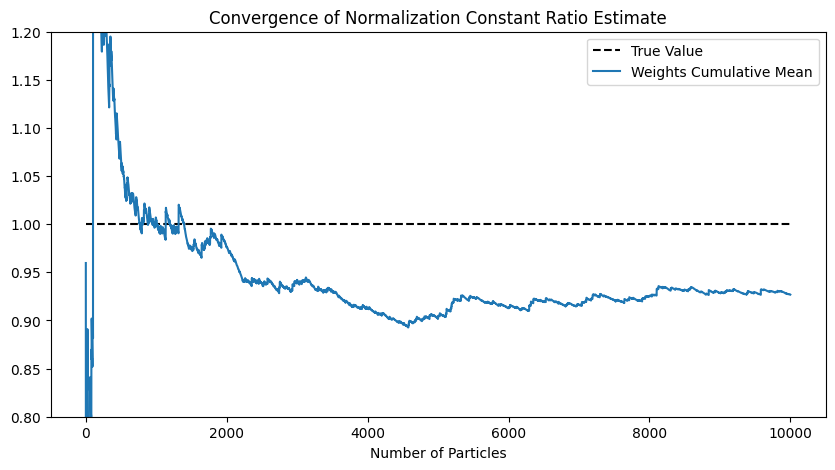

In [25]:
n_range = torch.arange(n_particles)
weights_cummean = log_weights.exp().cumsum(dim=0) / n_range
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.hlines(1, 1, n_particles, linestyle='--', color='black', label='True Value')
ax.plot(n_range, weights_cummean, label='Weights Cumulative Mean')
ax.set_ylim(0.8, 1.2)
ax.set_xlabel('Number of Particles')
ax.legend()
ax.set_title('Convergence of Normalization Constant Ratio Estimate');

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.70it/s]


Time step for optimal variance: 0.12239
Minimal variance: 5.03942


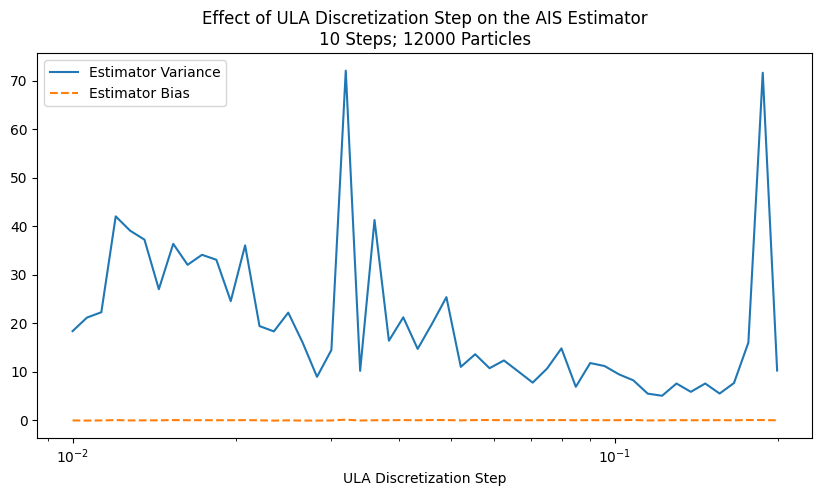

In [30]:
# ULA parameters
time_step_options = np.logspace(-2, -0.7, 50)
# AIS parameters
n_steps = 10
n_particles = 12000

test_logs = defaultdict(list)
for time_step in tqdm(time_step_options):
    transition_kernel = lambda distr: ULAKernel(distr, time_step)
    log_weights, target_samples = run_annealed_importance_sampling(proposal, target, n_steps, n_particles, transition_kernel)
    weights = log_weights.exp()
    test_logs['variance'].append(torch.var(weights))
    test_logs['bias'].append(torch.mean(weights) - 1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xscale('log')
ax.plot(time_step_options, test_logs['variance'], label='Estimator Variance')
ax.plot(time_step_options, test_logs['bias'], linestyle='--', label='Estimator Bias')
# ax.set_yscale('log')
ax.set_xlabel('ULA Discretization Step')
ax.legend()
ax.set_title(f'Effect of ULA Discretization Step on the AIS Estimator\n{n_steps} Steps; {n_particles} Particles');

best_i = np.argmin(test_logs['variance'])
best_time_step = time_step_options[best_i]
min_variance = test_logs['variance'][best_i]
print(f'Time step for optimal variance: {best_time_step:0.5f}')
print(f'Minimal variance: {min_variance:0.5f}')